Links:
- https://surprise.readthedocs.io/en/stable/getting_started.html
- https://surpriselib.com/


Inspiration:
- https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from collections import defaultdict


In [3]:
"""
Load dataset
"""
# Load the dataset (download it if needed)
data = Dataset.load_builtin('ml-100k')

# Convert to pandas dataframe
df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])

#print data from first 10 rows
print(df.head())
print(df.shape)

  user_id item_id  rating  timestamp
0     196     242     3.0  881250949
1     186     302     3.0  891717742
2      22     377     1.0  878887116
3     244      51     2.0  880606923
4     166     346     1.0  886397596
(100000, 4)


Number of ratings:
 4.0    34174
3.0    27145
5.0    21201
2.0    11370
1.0     6110
Name: rating, dtype: int64


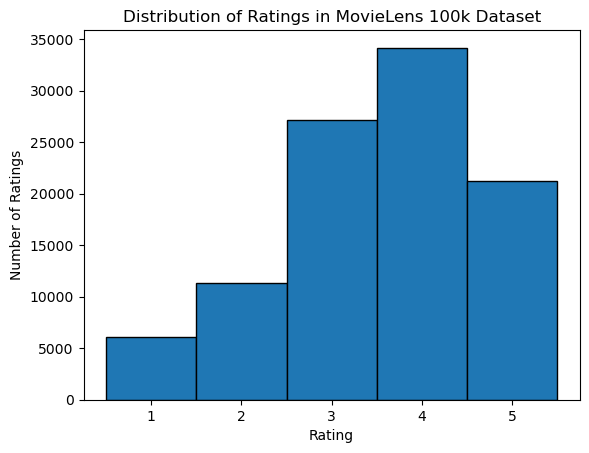

     item_id  rating
1128      50     583
859      258     509
2        100     508
774      181     507
899      294     485
890      286     481
892      288     478
0          1     452
907      300     431
235      121     429
    user_id  rating
340     405     737
617     655     685
34       13     636
390     450     540
196     276     518
352     416     493
486     537     490
227     303     484
150     234     480
326     393     448


In [4]:
"""
Exploratory Data Analysis (EDA) 
"""
rating_counts = df['rating'].value_counts()
print("Number of ratings:\n", rating_counts) 

plt.hist(df['rating'], bins=[1, 2, 3, 4, 5, 6], edgecolor='black', align="left")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings in MovieLens 100k Dataset")
plt.show()


#ratings per movie
n_movie_ratings = df.groupby('item_id')['rating'].count().reset_index().sort_values('rating', ascending=False)
print(n_movie_ratings.head(10))


#ratings per user 
n_user_ratings = df.groupby('user_id')['rating'].count().reset_index().sort_values('rating', ascending=False)
print(n_user_ratings.head(10))


In [5]:
"""
Define format
"""
#create an reader -> iterate through data
reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader=reader)


In [6]:
"""
Comparing RMSE for different algorithms using cross-validation
"""
benchmark = []

#iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    #perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)

    #get results and append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

#printing results 
results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
print(results)

C:\Users\emilh\AppData\Local\Temp\ipykernel_11720\2970333585.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
C:\Users\emilh\AppData\Local\Temp\ipykernel_11720\2970333585.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
C:\Users\emilh\AppData\Local\Temp\ipykernel_11720\2970333585.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
                 test_rmse  fit_time  test_time
Algorithm                                      
SVD               0.936039  1.038639   0.152841
NMF               0.962766  1.647867   0.147398
KNNBasic          0.978887  0.458195   2.909799
NormalPredictor   1.517960  0.124462   0.128093


C:\Users\emilh\AppData\Local\Temp\ipykernel_11720\2970333585.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


In [14]:
"""
Training and testing 
"""
#create trainset and testset
trainset, testset = train_test_split(data, test_size=.25)

#defines algorithms (probably try to tune parameters later , otherwise mention it in the report)
algo1 = SVD() #SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value) -> look at parameters
algo2 = NMF()
algo3 = NormalPredictor()
algo4 = KNNBasic()

#train and test algorithms
svd_predictions = algo1.fit(trainset).test(testset)
nmf_predictions = algo2.fit(trainset).test(testset)
normal_predictions = algo3.fit(trainset).test(testset)
knn_predictions = algo4.fit(trainset).test(testset)

#print answers
accuracy.rmse(svd_predictions)
accuracy.rmse(nmf_predictions)
accuracy.rmse(normal_predictions)
accuracy.rmse(knn_predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9365
RMSE: 0.9679
RMSE: 1.5203
RMSE: 0.9797


0.9797163452954194

In [ ]:
"""
Helper functions for interpretations 
"""

In [ ]:
"""

"""

Algorithms:
- NormalPredictor (Just random)
- BaselineOnly (Predicts the baseline estimate for a given user)
- KNNBasic
- SVD 
- NMF
- Kaggle (state of the art?)


#### Look at parameters values
Default values for SVD:
- n_factors - 100
- n_epochs - 20
- lr_all – 0.005
- reg_all – 0.02